# Project Title Here

**Names**: Sydney Casey, Jake Hunnius, Ben Leidig, Lily Novosel

You can delete and add as many code blocks as you like or change the formatting.

## 1. Introduction - Sydney

Research Introduction and Motivation
* Clearly state the motivation for why someone might want to learn more about the inherent
clusters that exist in this dataset.
* Describe at least one type of person/application that may find your cluster analysis useful
and how they might use it. Be specific about how they might use it.
* Your explanation should include: clear "next steps" for what your motivation person might
do with the results of your analysis.
* Your explanation should include: the downside of a clustering algorithm NOT finding all of
6
the inherent clusters in this particular dataset.
* Your explanation should include: the downside of a clustering algorithm erroneously
"splitting" an inherent cluster in this particular dataset.
* Your explanation should include what kind of clustering result outputs (ie. hard partition,
fuzzy clustering, dendrogram) might be useful to your research motivation and why.
* You should use at least **ONE CITATION** that support your motivation/answers in this section.
* Make sure that your citations are referenced and cited appropriately in this document.

Summarization of Sections
* Your introduction should also give a brief description of what you will do in each section of
2
this report (at most 1 sentence for each section).
----
- Younger people in our age group
- Drug addiction in developing adults
- Identify which states have best / worst support for youth for drug use
- State legislator tracking funding for drug abuse programs
- Federal legislator overseeing which states have the best programs
- Next steps: contact underperforming states and reallocating funds (if a federal legislator)
- Downside: missing valuable, nuanced information on drug use within states
- Be sure to mention why fuzzy clustering might be useful (subclusters, nearness of clusters)
- Be sure to mention why dendrograms / HAC might be useful (similarity between states / clusters, outliers)
- Summarize future sections!

https://corgis-edu.github.io/corgis/csv/drugs/

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [17]:
df = pd.read_csv('drugs.csv')
states = df['State'].unique().tolist()
df = df\
    .groupby('State').agg('mean')\
    .reset_index()\
    .drop(columns=[col for col in df.columns if (not col.startswith("Rates") or not col.endswith('.18-25'))])
X = df.to_numpy()

## 2. Dataset Discussion - Lily

Dataset Display
* Read your csv file and display the first 5 rows of your dataframe.
* How many rows are in your dataframe (originally before any data cleaning)?

Dataset Source
* State where YOU got this csv file (dataset) from.
* Provide a link/reference to where it came from.
* State when you downloaded this csv file.

Original Dataset Information In the place where you found this dataset, try to answer the
following questions. If the source does not give the answer to these questions, say so. 4
13
* What do the rows (ie. observations) represent in this dataset?
* How was this dataset collected?
* Is this dataset inclusive of ALL possible types of observations that could have been
considered in this dataset? If not, what types of observations might be left out?

Selected Variables
* Briefly describe the variables you intend to use in your analysis.
* Why do you think the inclusion of these variables are best when it comes to your research motivation?
* Should each of these variable be considered equally important in the analysis?

## 3. Dataset Cleaning and Exploration - Jake

Missing Value Detection and Cleaning
* Does your dataset have any missing values?
* If so, clean these missing values.
* Are there any downsides to cleaning the missing values in this particular way?

Outlier Identification - Two Variable Outliers (IF YOUR DATASET IS IMAGES, YOU CAN SKIP)
*For every pair of numerical explanatory variables that you're using, create a scatterplot.
* Are you able to detect any outliers in these plots?

Outlier Identification - 3+ Variable Outliers
*Use either a (KNN distance plot or a single linkage dendrogram) to look for outliers including
those that can only be seen in 3 or more dimensions.
* How many outlier/noise points are being suggested?

Outlier Consideration
*In the context of your research motivation, what do you think should be done with any
identified outliers? Explain.
- Should they be dropped? If so, what are some of the pros and cons of dropping these
outliers?
- Should they be clustered in their own singleton clusters?
- Should they be clustered with larger clusters that may happen to be further away?
* If you identified outliers in your dataset, does this impact the type of clustering algorithms
or clustering evaluation metrics that you might use in your analysis? Explain.

Noise Consideration and Identification
* Use a technique discussed in this class to determine if your dataset has any noise.
*In the context of your research motivation, what do you think should be done with any
identified noise? Explain.
* If you identified noise in your dataset, does this impact the type of clustering algorithms or
clustering evaluation metrics that you might use in your analysis? Explain.

Other Data Cleaning
* Were there any other data cleaning steps that you deemed suitable for this analysis? What
were they? Why did you choose to perform this additional data cleaning?
* If there are, do so here.
* If you dropped rows, how many did you drop?

- No missing values
- Show scatterplots with outliers (not full pairplot)
- Show KNN plot for outliers or single linkage
- Outlier treatment --> definitely don't outliers, will look into further analysis about what to do with outliers
- Explain why outliers impact clustering method choice
- Talk about noise in the dataset
- Grouped by state, taking mean of only the `Rate` columns (so average of each state + DC over all years)

## 4. Basic Descriptive Analytics

* For your numerical attributes, calculate basic summary statistics about each attribute.
* For any categorical attributes (including the pre-assigned class labels, if your dataset has
any) count up the number of observations of each type.
* Determine if there exist are any strong pairwise relationships between the variables in your
dataset.

## 5. Scaling Decisions

From your analyses conducted here, discuss whether you should scale the dataset or not.
Explain why or why not. If you choose to scale, then do so in this section here.

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=df.columns)

## 6. Clusterability and Clustering Structure - Ben

t-SNE Plots + Clusterability Check
* Create some appropriate t-SNE plots (6 perplexity values, 2 random states each).
* Select a representative t-SNE plot that displays similar patterns seen across many plots.

Describe the Underlying Clustering Structure of the Dataset
What do your t-SNE plots suggest about the following:
* Is your dataset clusterable? (THE ANSWER TO THIS SHOULD BE YES)
* Approximately how many underlying clusters does the data have?
* What are the shapes of the underlying clusters?
* Are the clusters balanced in size?
* Are there are any clusters that are not well-separated?
* Is there any evidence of nested cluster relationships in this dataset?

Clustering Structure and Attribute Association
* Is there an association between each of the attributes and the clustering structure
suggested by the t-SNE plot? Show the appropriate visualizations to explain. (That is, you
should color-code your t-SNE plot by each of your attributes and talk about the amount of
association between the attribute labels and the t-SNE plot suggested clusters).

Understanding the t-SNE algorithm
* Caution your reader about 4 original dataset properties that your t-SNE plots are not able to reveal or represent.

- t-SNE : perplexity 9, random state 207
- dataset is clusterable
- About 4 clusters (with two groups of two subclusters)
- Spherical & elongated clusters
- Approximately balanced in size
- Evidence of not well separated clusters, or at least the presence of subclusters
- Talk more about presence of subclusters
- Caution about t-SNE limitations

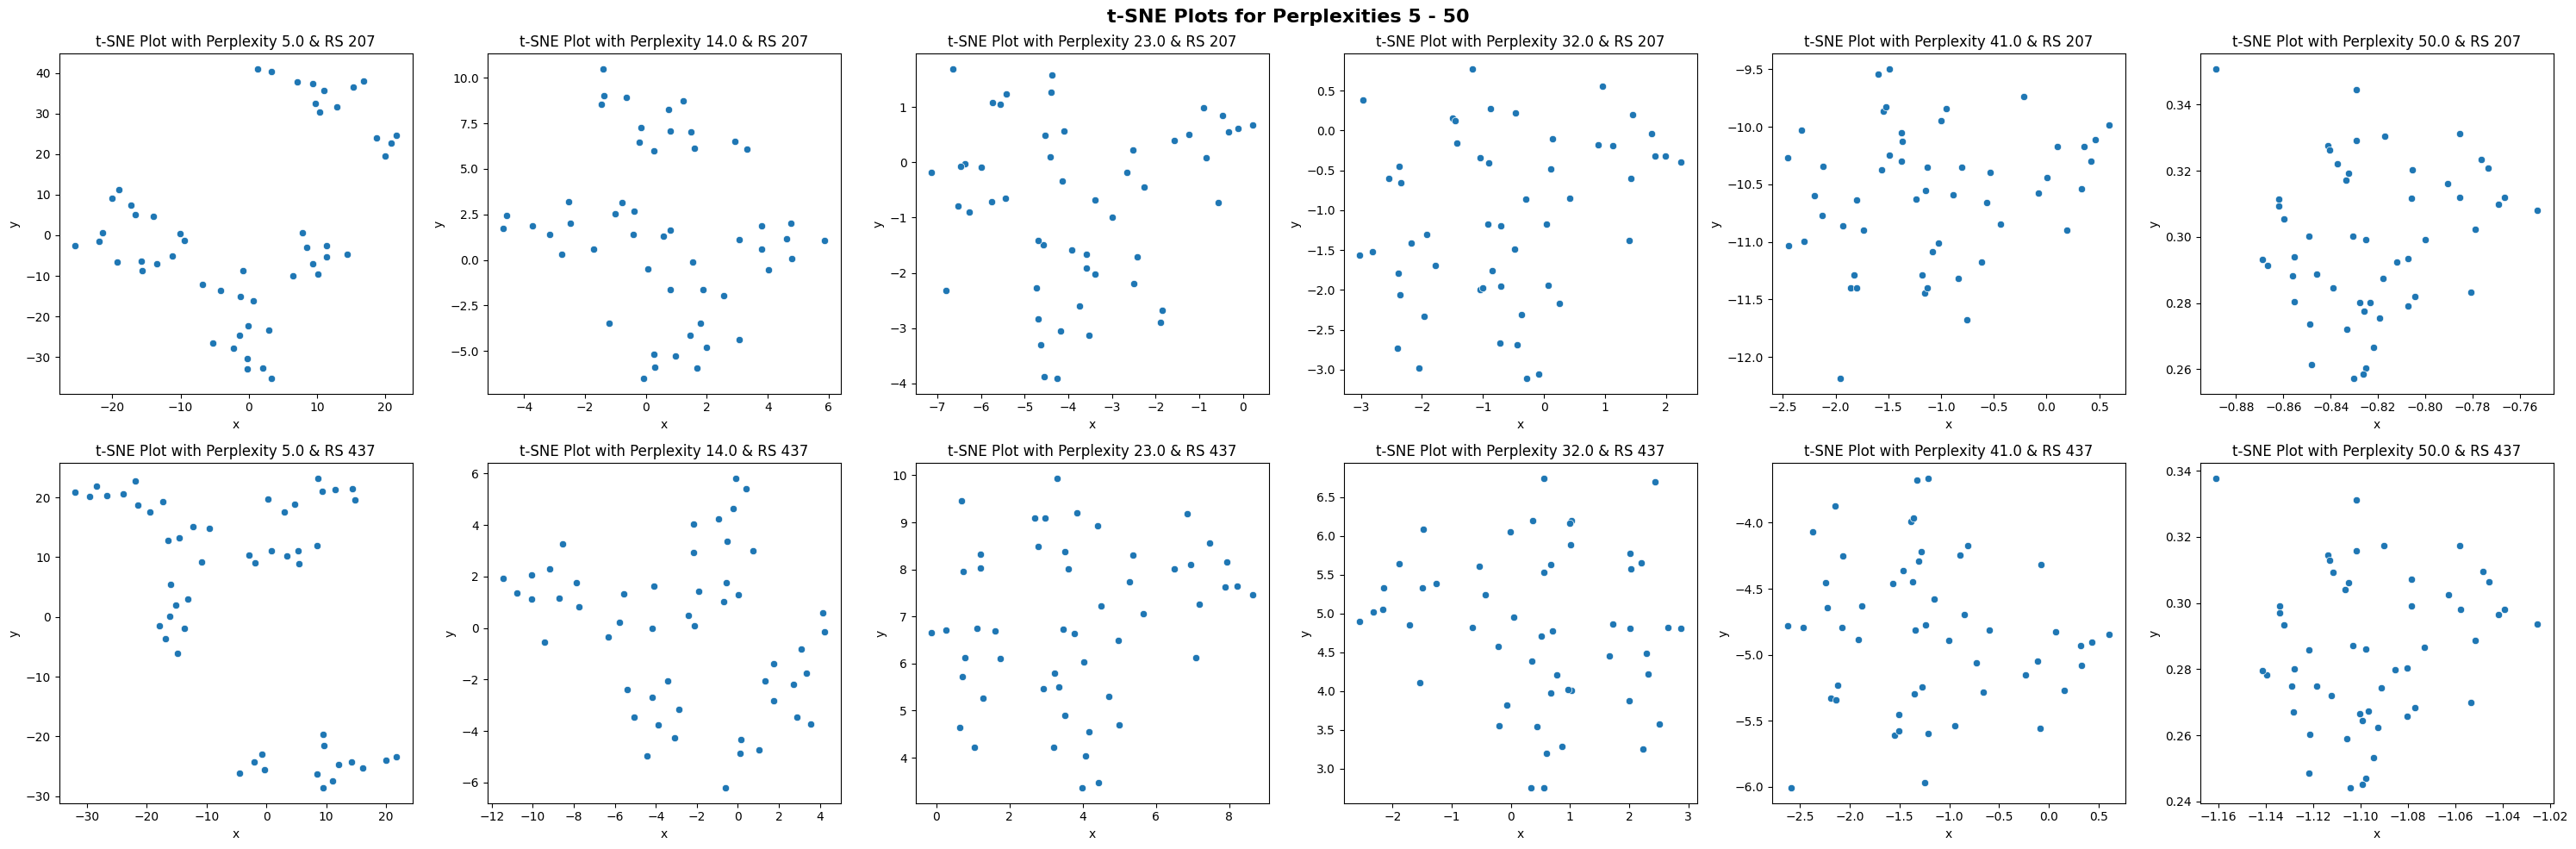

In [4]:
## 5 - 50 PERPLEXITY
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(30, 10))
for col, perp in enumerate(np.linspace(5, 50, 6)):
    for row, rs in enumerate((207, 437)):
        ax = axes[row, col]
        tsne = TSNE(
            n_components=2, init='random',
            perplexity=perp, random_state=rs
        )
        data_tsne = tsne.fit_transform(df_scaled)
        df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])
        sns.scatterplot(x='x', y='y', data=df_tsne, ax=ax)
        ax.set_title(f't-SNE Plot with Perplexity {perp} & RS {rs}')
fig.suptitle('t-SNE Plots for Perplexities 5 - 50', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

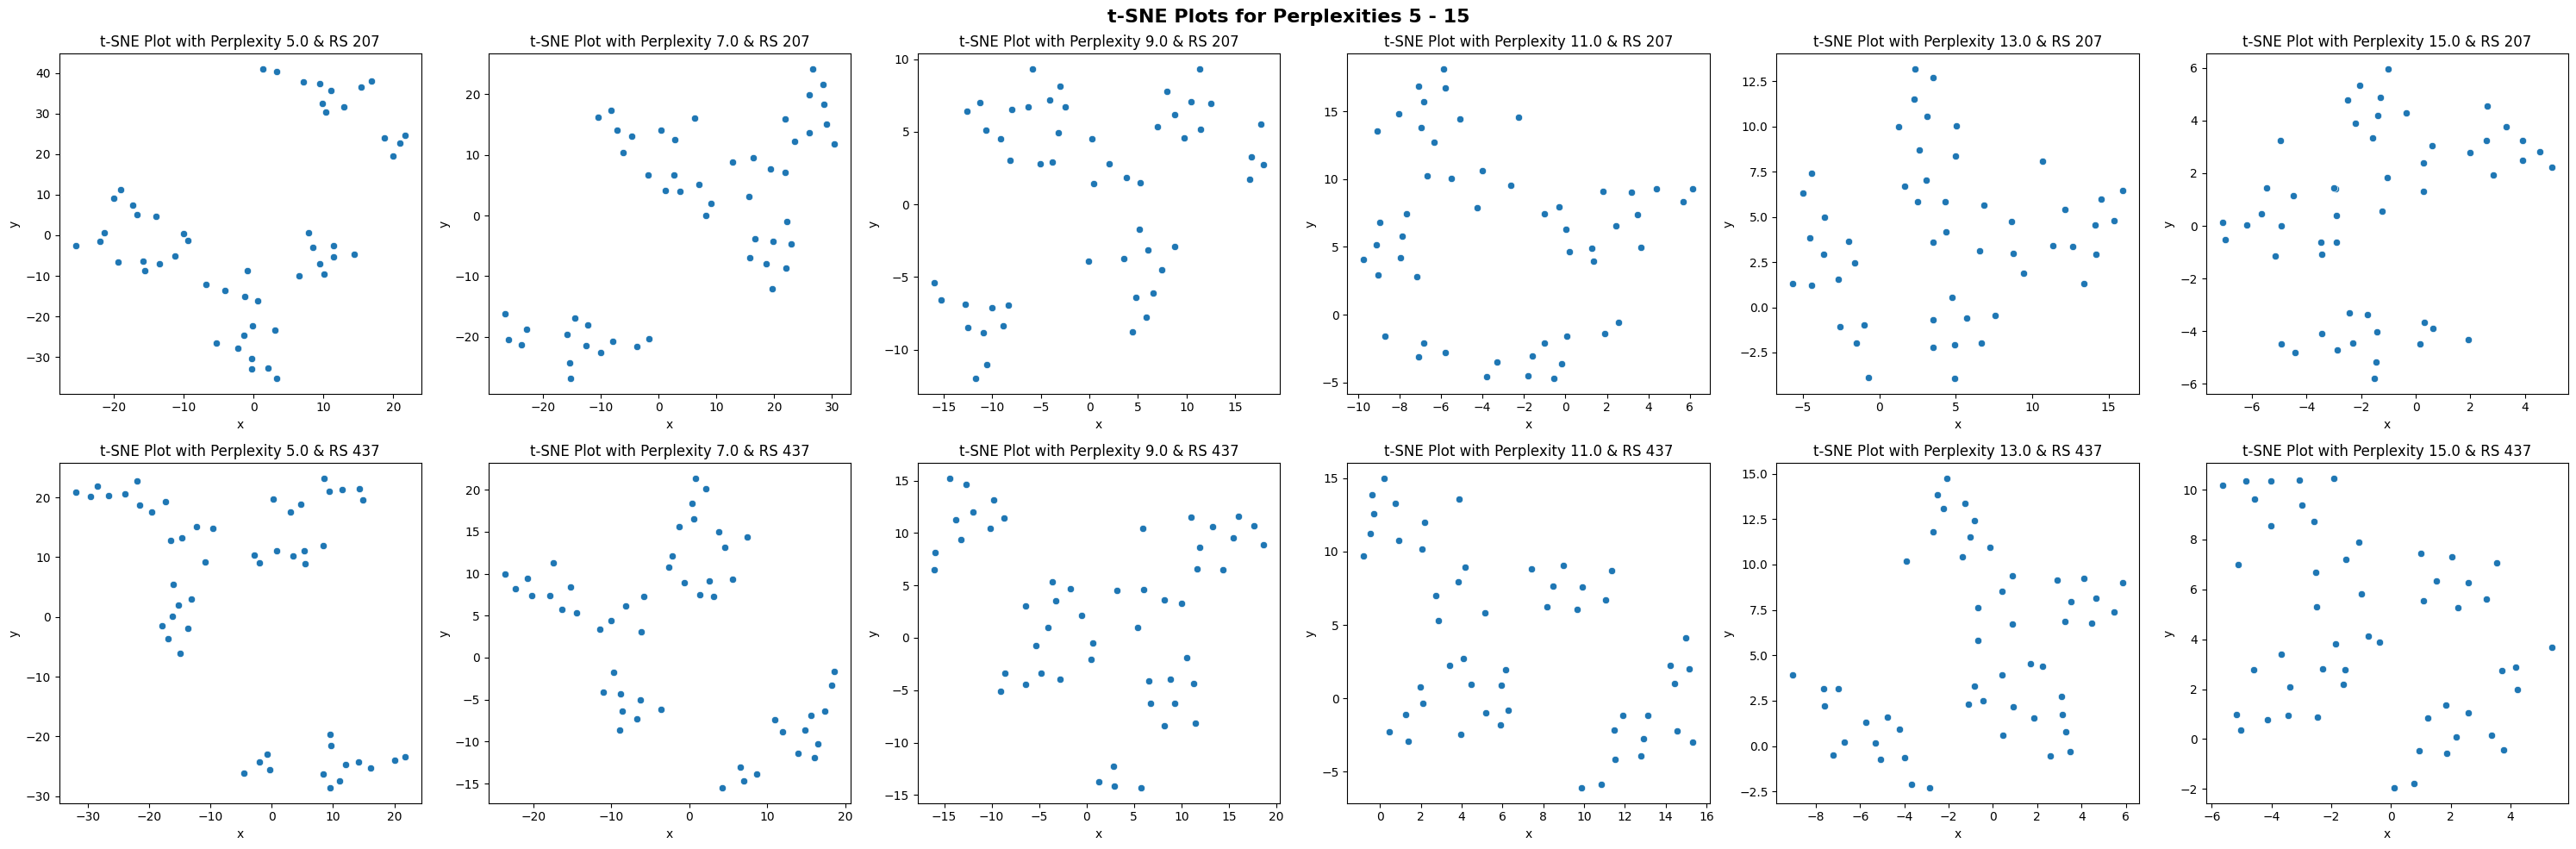

In [5]:
## 5 - 15 PERPLEXITY
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(30, 10))
for col, perp in enumerate(np.linspace(5, 15, 6)):
    for row, rs in enumerate((207, 437)):
        ax = axes[row, col]
        tsne = TSNE(
            n_components=2, init='random',
            perplexity=perp, random_state=rs
        )
        data_tsne = tsne.fit_transform(df_scaled)
        df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])
        sns.scatterplot(x='x', y='y', data=df_tsne, ax=ax)
        ax.set_title(f't-SNE Plot with Perplexity {perp} & RS {rs}')
fig.suptitle('t-SNE Plots for Perplexities 5 - 15', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

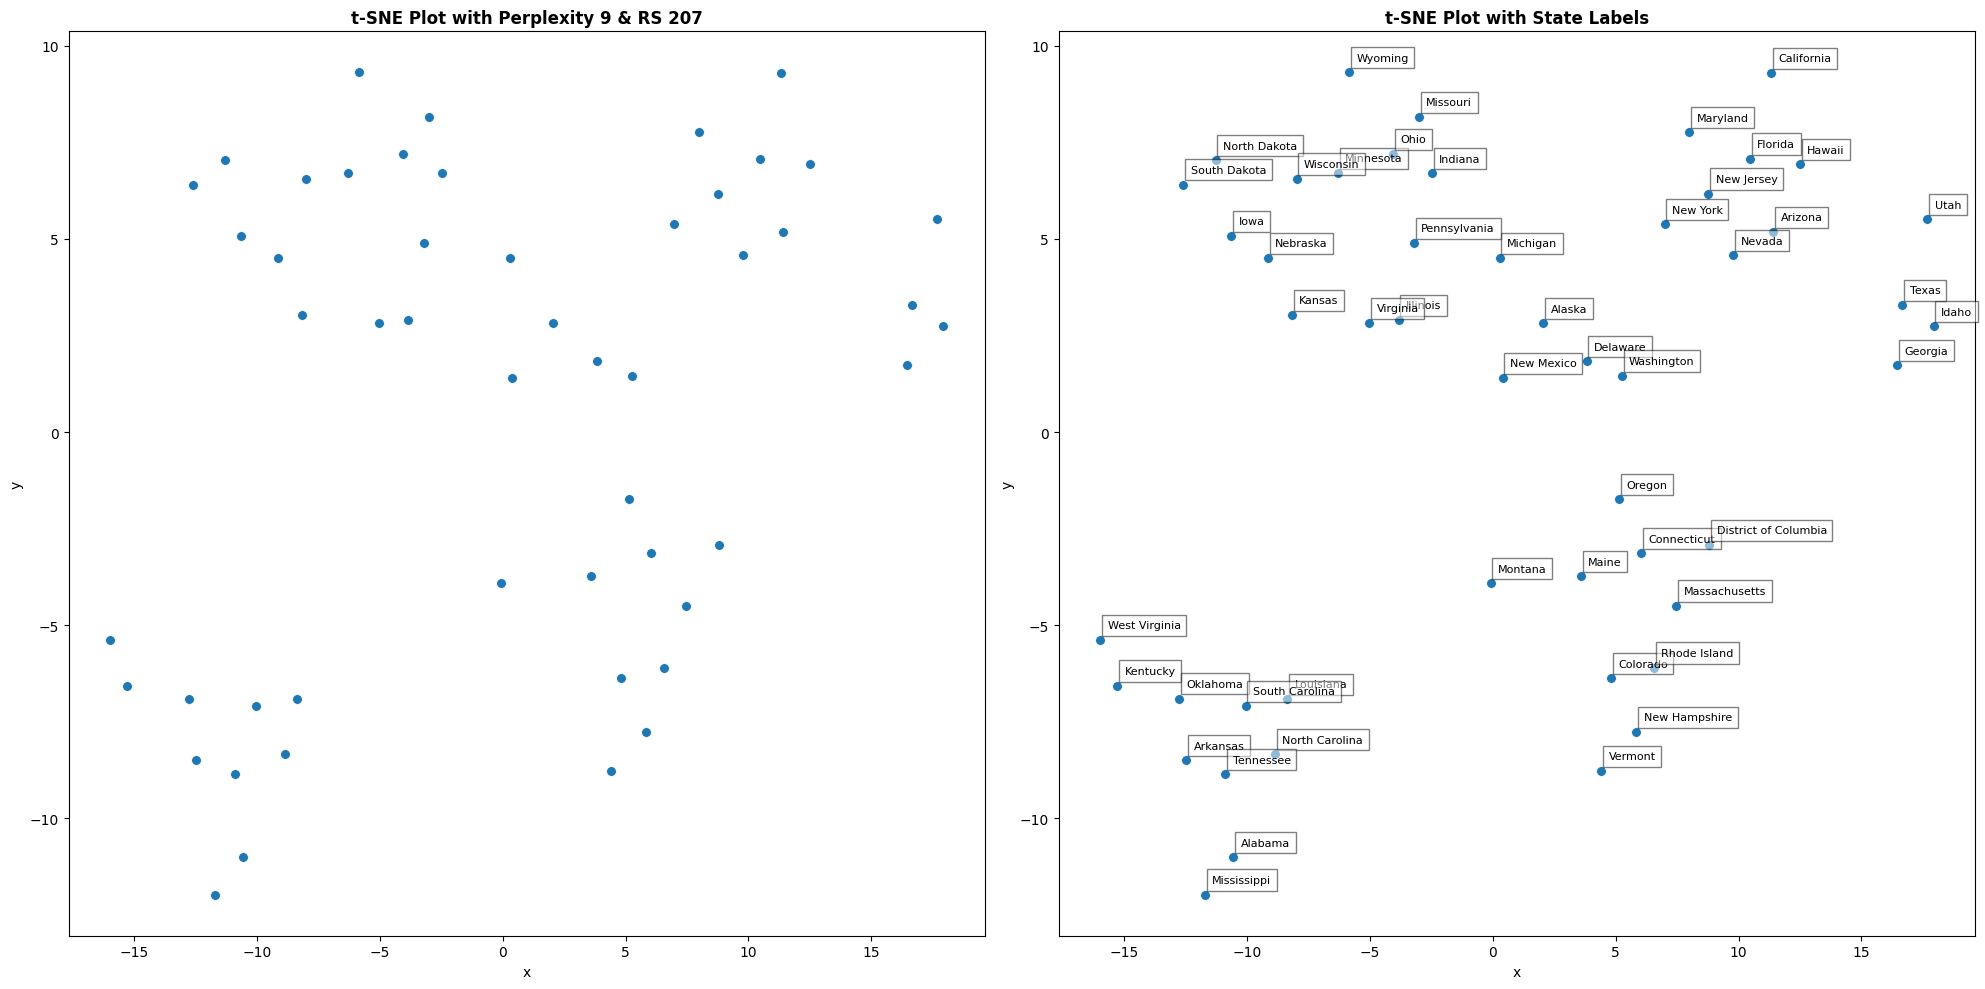

In [20]:
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
tsne = TSNE(
    n_components=2, init='random',
    perplexity=9, random_state=207
)
X_tsne = tsne.fit_transform(X_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y'])

sns.scatterplot(x='x', y='y', data=df_tsne, ax=ax0, s=50)
ax0.set_title('t-SNE Plot with Perplexity 9 & RS 207', fontweight='bold')

sns.scatterplot(x='x', y='y', data=df_tsne, ax=ax1, s=50)
ax1.set_title('t-SNE Plot with State Labels', fontweight='bold')
for i in range(df_tsne.shape[0]):
    ax1.text(
        x=df_tsne.loc[i, 'x']+0.3, y=df_tsne.loc[i, 'y']+0.3,
        s=states[i],
        fontdict=dict(color='black', size=8), bbox=dict(facecolor='white', alpha=0.5)
    )

plt.tight_layout()
plt.show()

First, twelve different t-SNE plots were made, each with a different perplexity value or random state value, between perplexities five through fifty. However, since there are only fifty-one observations in the dataset (the fifty United States plus the District of Columbia), high perplexity values (i.e., near fifty) approach $n$, the number of observations in the dataset. Accordingly, these t-SNE plots show little clustering structure. So, twelce new t-SNE plots were again made, but this time with perplexities spanning from five to fifteen, only. These plots demonstrate a clear clustering structure. 

## 7. Clustering Algorithm Selection Motivation

Clustering Algorithm #1
Explain why you chose to use your first clustering algorithm to cluster this dataset. In your
explanation, you should discuss and consider:
* your research motivation
* the "ideal dataset properties" that this algorithm is designed to work best for (your anaylses
above should give you a sense as to whether many of these ideal properties are met or not).
Your explanation should give at least 3 distinct reasons.
HINT: I OFTEN FIND A LOT OF INCORRECT AI SLOP IN THESE ANSWERS IN THE PAST. BE
CAREFUL.

Clustering Algorithm #2
Explain why you chose to use your first clustering algorith to cluster this dataset. In your
explanation, you should discuss and consider:
* your research motivation
* the "ideal dataset properties" that this algorithm is designed to work best for (your anaylses
above should give you a sense as to whether many of these ideal properties are met or not).
Your explanation should give at least 3 distinct reasons.
HINT: I OFTEN FIND A LOT OF INCORRECT AI SLOP IN THESE ANSWERS IN THE PAST. BE
CAREFUL.

## 8. Clustering Algorithm #1 - Complete Linkage (lily, ben)



## 9. Clustering Algorithm #2 - Fuzzy c-Means (jake, sydney)

## 10. Discussion

## 11. Conclusion

## References